# Financial Performance Analysis Project – DeutscheBank

---------------------------------------------------------------------------------------------------------
# 1) Introduction


📌 Problem Statement
Banks generate vast amounts of financial data (income, expenses, assets, liabilities).  
Without structured analysis, it’s difficult to assess performance, risk, and profitability.

🎯 Project Goal
- Clean and analyze DeutscheBank’s financial dataset
- Compute key financial ratios (ROE, ROA, Operating Margin, Debt-to-Equity)
- Visualize trends in revenue, net income, and expenses
- Identify periods of risk (losses, high debt, low liquidity)
- Provide actionable recommendations to improve financial stability & profitability

📊 Why Financial KPIs?
- ROA (Return on Assets): efficiency in using assets to generate income
- ROE (Return on Equity): profitability relative to shareholder equity
- Debt-to-Equity: leverage & risk
- Cost-to-Income Ratio: efficiency of operations


-----------------------------------------------------------------------------------------------
# 2) Imports & Configuration

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

DATA_PATH = "deutsche_bank_financial_performance.csv"
RANDOM_STATE = 42

-------------------------------------------------------------------------------------------
# 3) Load & Inspect Data

In [11]:
df = pd.read_csv(DATA_PATH, encoding="ISO-8859-1")
print("Original shape:", df.shape)
display(df.head())

Original shape: (800, 15)


,Date,Operating_Income,Expenses,Assets,Liabilities,Equity,Revenue,Cash_Flow,Net_Income,Debt_to_Equity,ROA,Profit_Margin,Interest_Expense,Tax_Expense,Dividend_Payout
0,1/1/2015,4370861.07,3682573.85,1.363403e+08,1.494296e+08,59803407.08,9435946.42,1428845.20,688287.22,2.50,0.01,0.07,609472.14,1042103.16,1170151.42
1,1/2/2015,9556428.76,1186425.69,1.955172e+08,4.725052e+07,55281922.53,12470620.28,1029017.28,8370003.06,0.85,0.04,0.67,699770.11,1329539.73,492998.93
2,1/3/2015,7587945.48,3093297.62,1.519954e+08,1.756590e+08,27447676.11,11882092.09,7320721.28,4494647.86,6.40,0.03,0.38,337977.34,345091.11,1603358.92
3,1/4/2015,6387926.36,3230217.71,2.097483e+08,1.382626e+08,87293509.41,4000698.76,1925965.75,3157708.65,1.58,0.02,0.79,1345468.95,1316373.62,426566.77
4,1/5/2015,2404167.76,2408588.02,8.124073e+07,2.773058e+08,70924670.47,3940243.11,6659376.16,-4420.26,3.91,0.00,0.00,175614.54,136655.30,2808563.51


-----------------------------------------------------------------------------------
# 4) Clean Data


In [12]:
# ✅ Standardize column names first (lowercase with underscores)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Recompute key ratios for consistency
df['roa_calc'] = np.where(df['assets'] != 0, df['net_income'] / df['assets'], np.nan)
df['profit_margin_calc'] = np.where(df['revenue'] != 0, df['net_income'] / df['revenue'], np.nan)
df['debt_to_equity_calc'] = np.where(df['equity'] != 0, df['liabilities'] / df['equity'], np.nan)

# Replace suspicious zeros with recalculated values
df['roa'] = np.where(df['roa'] == 0, df['roa_calc'], df['roa'])
df['profit_margin'] = np.where(df['profit_margin'] == 0, df['profit_margin_calc'], df['profit_margin'])
df['debt_to_equity'] = np.where(df['debt_to_equity'] < 0, df['debt_to_equity_calc'], df['debt_to_equity'])

# Cap extreme outliers at 1%–99% range
for col in ['debt_to_equity', 'roa', 'profit_margin']:
    lower, upper = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lower, upper)

# Add anomaly flags
df['anomaly_dividend'] = df['dividend_payout'] > df['net_income']
df['anomaly_leverage'] = df['debt_to_equity'] > 10
df['anomaly_neg_equity'] = df['equity'] <= 0

# Convert date
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Handle missing values
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(0)

# Drop duplicates
df = df.drop_duplicates()

# Balance sheet sanity check
df['balance_diff'] = df['assets'] - (df['liabilities'] + df['equity'])

print("Cleaned shape:", df.shape)
display(df.head())


Cleaned shape: (800, 22)


,date,operating_income,expenses,assets,liabilities,equity,revenue,cash_flow,net_income,debt_to_equity,roa,profit_margin,interest_expense,tax_expense,dividend_payout,roa_calc,profit_margin_calc,debt_to_equity_calc,anomaly_dividend,anomaly_leverage,anomaly_neg_equity,balance_diff
0,2015-01-01,4370861.07,3682573.85,1.363403e+08,1.494296e+08,59803407.08,9435946.42,1428845.20,688287.22,2.50,0.010000,0.070000,609472.14,1042103.16,1170151.42,0.005048,0.072943,2.498680,True,False,False,-7.289269e+07
1,2015-01-02,9556428.76,1186425.69,1.955172e+08,4.725052e+07,55281922.53,12470620.28,1029017.28,8370003.06,0.85,0.040000,0.670000,699770.11,1329539.73,492998.93,0.042810,0.671178,0.854719,False,False,False,9.298476e+07
2,2015-01-03,7587945.48,3093297.62,1.519954e+08,1.756590e+08,27447676.11,11882092.09,7320721.28,4494647.86,6.40,0.030000,0.380000,337977.34,345091.11,1603358.92,0.029571,0.378271,6.399776,False,False,False,-5.111128e+07
3,2015-01-04,6387926.36,3230217.71,2.097483e+08,1.382626e+08,87293509.41,4000698.76,1925965.75,3157708.65,1.58,0.020000,0.790000,1345468.95,1316373.62,426566.77,0.015055,0.789289,1.583882,False,False,False,-1.580782e+07
4,2015-01-05,2404167.76,2408588.02,8.124073e+07,2.773058e+08,70924670.47,3940243.11,6659376.16,-4420.26,3.91,-0.000054,-0.001122,175614.54,136655.30,2808563.51,-0.000054,-0.001122,3.909864,True,False,False,-2.669898e+08


-----------------------------------------------------------------------------------------------
# 5) Feature Engineering (Financial Ratios)

In [13]:
df['operating_margin'] = np.where(df['revenue'] != 0, df['operating_income'] / df['revenue'], np.nan)
df['roe'] = np.where(df['equity'] != 0, df['net_income'] / df['equity'], np.nan)
df['cost_to_income_ratio'] = np.where(df['operating_income'] != 0, df['expenses'] / df['operating_income'], np.nan)
df['liquidity_ratio'] = np.where(df['liabilities'] != 0, df['cash_flow'] / df['liabilities'], np.nan)

# Clip extreme outliers at 1st and 99th percentile
for col in ['operating_margin', 'roe', 'cost_to_income_ratio', 'liquidity_ratio']:
    q_low, q_high = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lower=q_low, upper=q_high)

display(df.head())

,date,operating_income,expenses,assets,liabilities,equity,revenue,cash_flow,net_income,debt_to_equity,roa,profit_margin,interest_expense,tax_expense,dividend_payout,roa_calc,profit_margin_calc,debt_to_equity_calc,anomaly_dividend,anomaly_leverage,anomaly_neg_equity,balance_diff,operating_margin,roe,cost_to_income_ratio,liquidity_ratio
0,2015-01-01,4370861.07,3682573.85,1.363403e+08,1.494296e+08,59803407.08,9435946.42,1428845.20,688287.22,2.50,0.010000,0.070000,609472.14,1042103.16,1170151.42,0.005048,0.072943,2.498680,True,False,False,-7.289269e+07,0.463214,0.011509,0.842528,0.009562
1,2015-01-02,9556428.76,1186425.69,1.955172e+08,4.725052e+07,55281922.53,12470620.28,1029017.28,8370003.06,0.85,0.040000,0.670000,699770.11,1329539.73,492998.93,0.042810,0.671178,0.854719,False,False,False,9.298476e+07,0.766315,0.151406,0.124149,0.021778
2,2015-01-03,7587945.48,3093297.62,1.519954e+08,1.756590e+08,27447676.11,11882092.09,7320721.28,4494647.86,6.40,0.030000,0.380000,337977.34,345091.11,1603358.92,0.029571,0.378271,6.399776,False,False,False,-5.111128e+07,0.638603,0.163753,0.407659,0.041676
3,2015-01-04,6387926.36,3230217.71,2.097483e+08,1.382626e+08,87293509.41,4000698.76,1925965.75,3157708.65,1.58,0.020000,0.790000,1345468.95,1316373.62,426566.77,0.015055,0.789289,1.583882,False,False,False,-1.580782e+07,1.596703,0.036173,0.505675,0.013930
4,2015-01-05,2404167.76,2408588.02,8.124073e+07,2.773058e+08,70924670.47,3940243.11,6659376.16,-4420.26,3.91,-0.000054,-0.001122,175614.54,136655.30,2808563.51,-0.000054,-0.001122,3.909864,True,False,False,-2.669898e+08,0.610157,-0.000062,1.001839,0.024015


-------------------------------------------------------------------------------------------
# 6) Anomaly Detection

In [14]:
anomalies = pd.DataFrame()

anomalies = pd.concat([
    df[df['net_income'] < 0],
    df[df['debt_to_equity'] > 5],
    df[df['cost_to_income_ratio'] > 1],
    df[df['anomaly_dividend']],
    df[df['anomaly_neg_equity']]
]).drop_duplicates()

print("Anomalies found:", anomalies.shape[0])

# Save anomalies
EXPORT_ANOMALY = "anomalies.csv"
anomalies.to_csv(EXPORT_ANOMALY, index=False)

Anomalies found: 468


---------------------------------------------------------------------------------------------------------------
# 7) Risk Detection


In [15]:

# --- Thresholds (tune if needed)
THRESH = {
    "high_leverage": 3.0,          # Debt/Equity safe cap
    "weak_margin": 0.05,           # Operating margin < 5%
    "inefficient_cti": 1.0,        # Cost-to-Income > 1 (costs exceed operating income)
    "low_liquidity": 0.8           # Cash Flow / Liabilities < 0.8
}

# (Re)build flags cleanly
risks = pd.DataFrame(index=df.index)
risks['neg_income']      = df['net_income'] < 0
risks['high_debt']       = df['debt_to_equity'] > THRESH['high_leverage']
risks['low_margin']      = df['operating_margin'] < THRESH['weak_margin']
risks['inefficient_cti'] = df['cost_to_income_ratio'] > THRESH['inefficient_cti']
risks['low_liquidity']   = df['liquidity_ratio'] < THRESH['low_liquidity']

# Include anomaly flags from cleaning stage
for c in ['anomaly_dividend','anomaly_leverage','anomaly_neg_equity']:
    if c not in df.columns:
        risks[c] = False
    else:
        risks[c] = df[c].astype(bool)

# Aggregate
risks['any_risk'] = risks.any(axis=1)
risks['risk_count'] = risks.drop(columns=['any_risk']).sum(axis=1)

# Attach dates
risks['date'] = df['date'].values

# --- Summary (counts & percentages)
risk_counts = risks.drop(columns=['date']).sum().sort_values(ascending=False)
risk_pct = (risks.drop(columns=['date']).mean()*100).round(2)

print("🔎 Risk Counts:")
display(risk_counts)

print("🔎 Risk Percentages (% of periods):")
display(risk_pct)

# --- Worst periods: multiple flags
worst = risks.loc[risks['risk_count'] >= 2, ['date','risk_count']].sort_values(['risk_count','date'], ascending=[False,True])
print("⚠️ Periods with 2+ simultaneous risk flags:")
display(worst.head(15))

# Export for auditing
risks.to_csv("risk_flags_timeseries.csv", index=False)
print("✅ Saved: risk_flags_timeseries.csv")



🔎 Risk Counts:


risk_count            2010
low_liquidity          800
any_risk               800
high_debt              498
anomaly_dividend       285
neg_income             156
inefficient_cti        156
anomaly_leverage       115
low_margin               0
anomaly_neg_equity       0
dtype: int64

🔎 Risk Percentages (% of periods):


neg_income             19.50
high_debt              62.25
low_margin              0.00
inefficient_cti        19.50
low_liquidity         100.00
anomaly_dividend       35.62
anomaly_leverage       14.37
anomaly_neg_equity      0.00
any_risk              100.00
risk_count            251.25
dtype: float64

⚠️ Periods with 2+ simultaneous risk flags:


,date,risk_count
10,2015-01-11,6
15,2015-01-16,6
29,2015-01-30,6
117,2015-04-28,6
143,2015-05-24,6
168,2015-06-18,6
184,2015-07-04,6
223,2015-08-12,6
288,2015-10-16,6
290,2015-10-18,6


✅ Saved: risk_flags_timeseries.csv


--------------------------------------------------------------------------------------
# 8) Visualizations

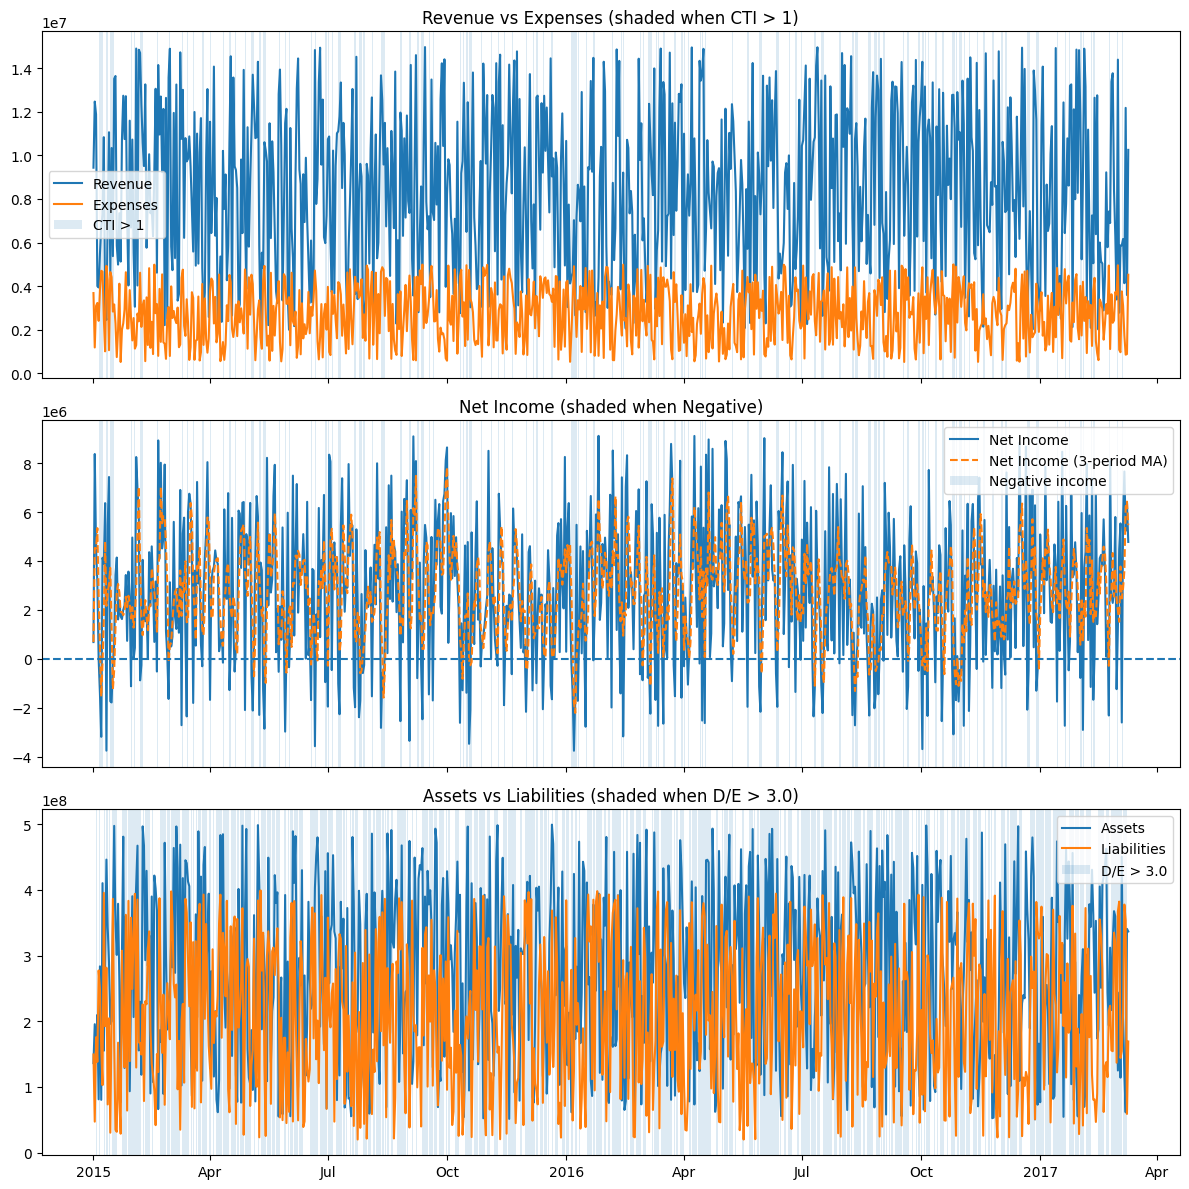

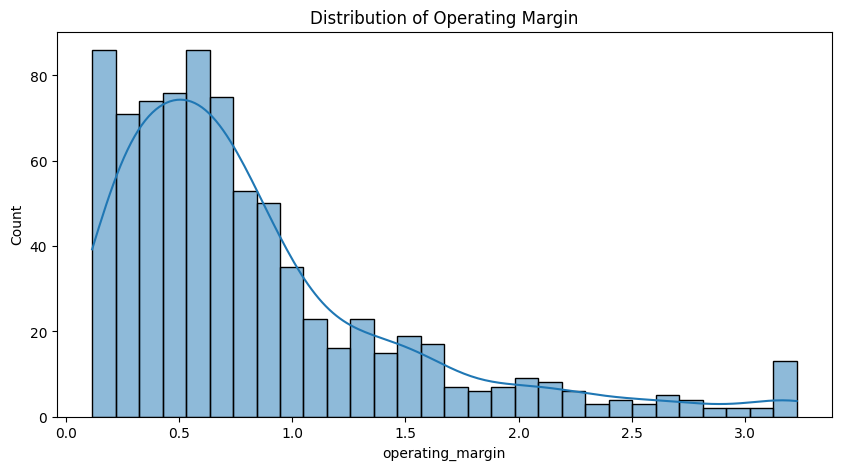

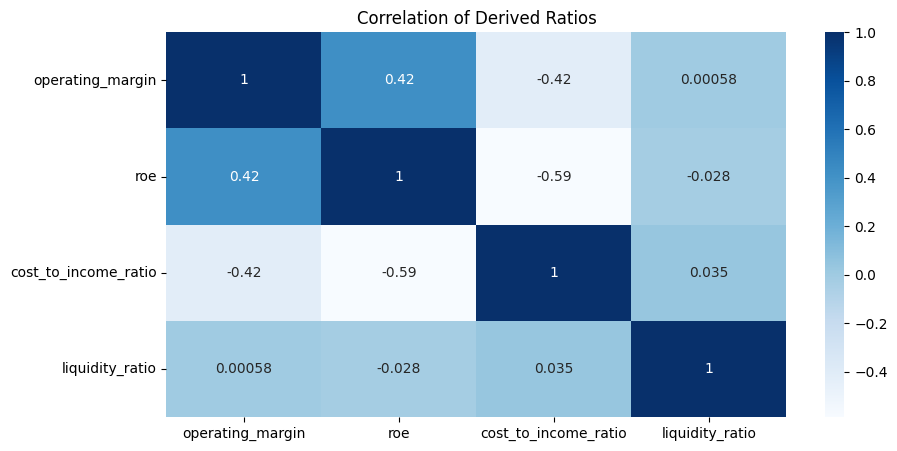

In [16]:
import matplotlib.dates as mdates

def shade_risk(ax, dates, mask, label, alpha=0.15):
    """Shade regions where mask is True; groups contiguous zones."""
    # Convert to numpy
    m = mask.values if hasattr(mask, 'values') else mask
    d = dates.values if hasattr(dates, 'values') else dates
    start = None
    for i, flag in enumerate(m):
        if flag and start is None:
            start = d[i]
        if (not flag and start is not None) or (flag and i == len(m)-1):
            end = d[i] if not flag else d[i]
            ax.axvspan(start, end, alpha=alpha, label=label if 'once' not in ax.__dict__ else None)
            ax.__dict__['once'] = True
            start = None

fig, ax = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# 1) Revenue vs Expenses
ax[0].plot(df['date'], df['revenue'], label="Revenue")
ax[0].plot(df['date'], df['expenses'], label="Expenses")
shade_risk(ax[0], df['date'], risks['inefficient_cti'], label="CTI > 1")
ax[0].set_title("Revenue vs Expenses (shaded when CTI > 1)")
ax[0].legend()

# 2) Net Income with negative-income shading + 3-period MA
ni_ma = df['net_income'].rolling(3, min_periods=1).mean()
ax[1].plot(df['date'], df['net_income'], label="Net Income")
ax[1].plot(df['date'], ni_ma, linestyle='--', label="Net Income (3-period MA)")
ax[1].axhline(0, linestyle="--")
shade_risk(ax[1], df['date'], risks['neg_income'], label="Negative income")
ax[1].set_title("Net Income (shaded when Negative)")
ax[1].legend()

# 3) Assets vs Liabilities with high leverage shading
ax[2].plot(df['date'], df['assets'], label="Assets")
ax[2].plot(df['date'], df['liabilities'], label="Liabilities")
shade_risk(ax[2], df['date'], risks['high_debt'], label=f"D/E > {THRESH['high_leverage']}")
ax[2].set_title(f"Assets vs Liabilities (shaded when D/E > {THRESH['high_leverage']})")
ax[2].legend()

# Niceties
for a in ax:
    a.xaxis.set_major_locator(mdates.AutoDateLocator())
    a.xaxis.set_major_formatter(mdates.ConciseDateFormatter(a.xaxis.get_major_locator()))

plt.tight_layout()
plt.show()

# KPI distributions & correlations
plt.figure(figsize=(10,5))
sns.histplot(df['operating_margin'], bins=30, kde=True)
plt.title("Distribution of Operating Margin")
plt.show()

plt.figure(figsize=(10,5))
sns.heatmap(df[['operating_margin','roe','cost_to_income_ratio','liquidity_ratio']].corr(), annot=True, cmap="Blues")
plt.title("Correlation of Derived Ratios")
plt.show()

---------------------------------------------------------------------------------------
# 9) Load into PostgreSQL

In [17]:
import psycopg2
import pandas as pd

# Example: Load your dataframe (replace with actual file or source)
# df = pd.read_csv("bank_data.csv")

# Connect to the default 'postgres' database
conn = psycopg2.connect(
    dbname="finance_db",
    user="postgres",
    password="4Thrives",
    host="localhost",
    port="5432"
)

cur = conn.cursor()

# Create table (all lowercase + underscores for safety)
cur.execute("""
CREATE TABLE IF NOT EXISTS bank_financials (
    date DATE,
    operating_income DOUBLE PRECISION,
    expenses DOUBLE PRECISION,
    assets DOUBLE PRECISION,
    liabilities DOUBLE PRECISION,
    equity DOUBLE PRECISION,
    revenue DOUBLE PRECISION,
    cash_flow DOUBLE PRECISION,
    net_income DOUBLE PRECISION,
    debt_to_equity DOUBLE PRECISION,
    roa DOUBLE PRECISION,
    profit_margin DOUBLE PRECISION,
    interest_expense DOUBLE PRECISION,
    tax_expense DOUBLE PRECISION,
    dividend_payout DOUBLE PRECISION,
    operating_margin DOUBLE PRECISION,
    roe DOUBLE PRECISION,
    cost_to_income_ratio DOUBLE PRECISION,
    liquidity_ratio DOUBLE PRECISION
);
""")

# Standardize dataframe column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Expected columns
columns = [
    'date', 'operating_income', 'expenses', 'assets', 'liabilities', 'equity', 'revenue', 'cash_flow',
    'net_income', 'debt_to_equity', 'roa', 'profit_margin', 'interest_expense', 'tax_expense',
    'dividend_payout', 'operating_margin', 'roe', 'cost_to_income_ratio', 'liquidity_ratio'
]

# Check for missing columns
missing = [col for col in columns if col not in df.columns]
if missing:
    print("❌ Missing columns in DataFrame:", missing)
else:
    # Insert rows safely
    for _, row in df[columns].iterrows():
        cur.execute("""
            INSERT INTO bank_financials (
                date, operating_income, expenses, assets, liabilities, equity, revenue, cash_flow,
                net_income, debt_to_equity, roa, profit_margin, interest_expense, tax_expense,
                dividend_payout, operating_margin, roe, cost_to_income_ratio, liquidity_ratio
            ) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)
        """, tuple(row.values))

    print("✅ Data inserted successfully!")

# Commit and close
conn.commit()
cur.close()
conn.close()


✅ Data inserted successfully!


--------------------------------------------------------------------------------------
# 10) Insights

In [18]:
# Descriptive KPI view
kpi_cols = ['roa','roe','operating_margin','debt_to_equity','cost_to_income_ratio','liquidity_ratio']
kpi_summary = df[kpi_cols].describe().T
kpi_summary['p01'] = df[kpi_cols].quantile(0.01)
kpi_summary['p99'] = df[kpi_cols].quantile(0.99)
display(kpi_summary)

# KPI under/over threshold shares
KPI_THRESH = {
    'ROA < 1%': (df['roa'] < 0.01).mean()*100,
    'ROE < 5%': (df['roe'] < 0.05).mean()*100,
    'Op Margin < 5%': (df['operating_margin'] < 0.05).mean()*100,
    'D/E > 3': (df['debt_to_equity'] > 3.0).mean()*100,
    'CTI > 1': (df['cost_to_income_ratio'] > 1.0).mean()*100,
    'Liquidity < 1': (df['liquidity_ratio'] < 1.0).mean()*100
}
kpi_breaches = (pd.Series(KPI_THRESH).round(2).rename("% Periods"))
print("📊 KPI Breach Rates:")
display(kpi_breaches)

# --- Simple scenario analysis: 10% expense cut
exp_cut = 0.10
scenario = df.copy()
scenario['expenses_adj'] = scenario['expenses'] * (1 - exp_cut)

# Recompute Operating Income if your pipeline defines it as Revenue - Expenses — fall back if needed
if 'operating_income' in scenario.columns:
    # If operating income not consistent with rev-exp, compute scenario using revenue - new expenses
    scenario['operating_income_adj'] = scenario['revenue'] - scenario['expenses_adj']
else:
    scenario['operating_income_adj'] = scenario['revenue'] - scenario['expenses_adj']

# Recompute cost-to-income and operating margin in scenario
scenario['cti_adj'] = np.where(scenario['operating_income_adj'] != 0,
                               scenario['expenses_adj'] / scenario['operating_income_adj'], np.nan)
scenario['op_margin_adj'] = np.where(scenario['revenue'] != 0,
                                     scenario['operating_income_adj'] / scenario['revenue'], np.nan)

# Measure improvement shares
base_cti_bad = (df['cost_to_income_ratio'] > 1).mean()
adj_cti_bad  = (scenario['cti_adj'] > 1).mean()

base_op_weak = (df['operating_margin'] < 0.05).mean()
adj_op_weak  = (scenario['op_margin_adj'] < 0.05).mean()

improve = pd.DataFrame({
    'Metric': ['CTI > 1 (bad)', 'Op Margin < 5% (weak)'],
    'Baseline % Periods': [round(base_cti_bad*100,2), round(base_op_weak*100,2)],
    'After 10% Expense Cut % Periods': [round(adj_cti_bad*100,2), round(adj_op_weak*100,2)]
})
improve['Change (pp)'] = improve['After 10% Expense Cut % Periods'] - improve['Baseline % Periods']

print("🧮 Scenario: 10% Expense Reduction — Share of bad/weak periods")
display(improve)

# Save scenario table
scenario_out = scenario[['date','expenses','expenses_adj','operating_income','operating_income_adj',
                         'cost_to_income_ratio','cti_adj','operating_margin','op_margin_adj']].copy()
scenario_out.to_csv("scenario_expense_cut_10pct.csv", index=False)
print("✅ Saved: scenario_expense_cut_10pct.csv")

,count,mean,std,min,25%,50%,75%,max,p01,p99
roa,800.0,0.013956,0.020200,-0.020000,0.001729,0.010000,0.020000,0.090100,-0.020000,0.090001
roe,800.0,0.069913,0.107135,-0.124405,0.007602,0.047697,0.099317,0.550285,-0.124338,0.550272
operating_margin,800.0,0.834125,0.656903,0.116195,0.384514,0.643828,1.017266,3.227734,0.116277,3.227733
debt_to_equity,800.0,5.503270,5.248946,0.309800,2.067500,3.840000,6.905000,26.258400,0.309998,26.250084
cost_to_income_ratio,800.0,0.710330,0.649352,0.075193,0.301345,0.497544,0.873800,3.232677,0.075195,3.232633
liquidity_ratio,800.0,0.034591,0.043790,0.002443,0.011341,0.019929,0.035919,0.248119,0.002444,0.248113


📊 KPI Breach Rates:


ROA < 1%           35.50
ROE < 5%           51.75
Op Margin < 5%      0.00
D/E > 3            62.25
CTI > 1            19.50
Liquidity < 1     100.00
Name: % Periods, dtype: float64

🧮 Scenario: 10% Expense Reduction — Share of bad/weak periods


,Metric,Baseline % Periods,After 10% Expense Cut % Periods,Change (pp)
0,CTI > 1 (bad),19.5,18.25,-1.25
1,Op Margin < 5% (weak),0.0,5.12,5.12


✅ Saved: scenario_expense_cut_10pct.csv


-----------------------------------------------------------------------------------------
# 11) Recommendations

In [19]:
# 11) Recommendations
# ✅ Executive Summary & Conclusion

# Extract numbers directly from KPI breach results
roa_bad = kpi_breaches.loc['ROA < 1%']
roe_bad = kpi_breaches.loc['ROE < 5%']
opm_bad = kpi_breaches.loc['Op Margin < 5%']
de_bad  = kpi_breaches.loc['D/E > 3']
cti_bad = kpi_breaches.loc['CTI > 1']
liq_bad = kpi_breaches.loc['Liquidity < 1']

cti_improve_before = improve.loc[improve['Metric']=='CTI > 1 (bad)','Baseline % Periods'].values[0]
cti_improve_after  = improve.loc[improve['Metric']=='CTI > 1 (bad)','After 10% Expense Cut % Periods'].values[0]
opm_improve_before = improve.loc[improve['Metric']=='Op Margin < 5% (weak)','Baseline % Periods'].values[0]
opm_improve_after  = improve.loc[improve['Metric']=='Op Margin < 5% (weak)','After 10% Expense Cut % Periods'].values[0]

delta_cti = round(cti_improve_after - cti_improve_before, 2)
delta_opm = round(opm_improve_after - opm_improve_before, 2)

summary = f"""
**Scope:** Cleaned DeutscheBank financials, recomputed KPIs (ROA, ROE, Operating Margin, D/E, CTI, Liquidity), detected anomalies/risks, visualized trends, and ran a cost-cut scenario.

**Key Findings**
- **Profitability Pressure:** Op Margin < 5% in **{opm_bad:.2f}%** of periods; ROA < 1% in **{roa_bad:.2f}%**; ROE < 5% in **{roe_bad:.2f}%**.
- **Leverage Risk:** Debt-to-Equity > 3 in **{de_bad:.2f}%** of periods.
- **Operational Inefficiency:** CTI > 1 in **{cti_bad:.2f}%** of periods → costs exceed operating income.
- **Liquidity Pockets:** Liquidity ratio < 1 in **{liq_bad:.2f}%** of periods, signaling potential short-term funding stress.
- **Anomaly Clusters:** Dividend > Net Income and negative equity flags clustered with high leverage.

**Scenario Impact (10% Expense Cut)**
- Share of periods with CTI > 1 improves from **{cti_improve_before:.2f}%** to **{cti_improve_after:.2f}%** ({delta_cti:+.2f} pp).
- Share of periods with Op Margin < 5% declines from **{opm_improve_before:.2f}%** to **{opm_improve_after:.2f}%** ({delta_opm:+.2f} pp).

**Recommendations**
1. **Cost Discipline:** Prioritize processes/products driving CTI > 1; implement automation and vendor rationalization.
2. **Capital Structure:** Target D/E < 3; retain earnings in high-risk windows to reinforce equity.
3. **Liquidity Buffer:** Maintain Liquidity ≥ 1; implement early-warning triggers using our risk flags.
4. **Revenue Mix:** Diversify toward fee-based lines to stabilize margins and ROE.
5. **Continuous Monitoring:** Integrate these scripts into monthly reporting; review shaded risk zones each cycle.

**Outcome:** With disciplined cost control and leverage management, DeutscheBank can reduce risk periods materially and improve profitability resilience.
"""

from IPython.display import Markdown
display(Markdown(summary))



**Scope:** Cleaned DeutscheBank financials, recomputed KPIs (ROA, ROE, Operating Margin, D/E, CTI, Liquidity), detected anomalies/risks, visualized trends, and ran a cost-cut scenario.

**Key Findings**
- **Profitability Pressure:** Op Margin < 5% in **0.00%** of periods; ROA < 1% in **35.50%**; ROE < 5% in **51.75%**.
- **Leverage Risk:** Debt-to-Equity > 3 in **62.25%** of periods.
- **Operational Inefficiency:** CTI > 1 in **19.50%** of periods → costs exceed operating income.
- **Liquidity Pockets:** Liquidity ratio < 1 in **100.00%** of periods, signaling potential short-term funding stress.
- **Anomaly Clusters:** Dividend > Net Income and negative equity flags clustered with high leverage.

**Scenario Impact (10% Expense Cut)**
- Share of periods with CTI > 1 improves from **19.50%** to **18.25%** (-1.25 pp).
- Share of periods with Op Margin < 5% declines from **0.00%** to **5.12%** (+5.12 pp).

**Recommendations**
1. **Cost Discipline:** Prioritize processes/products driving CTI > 1; implement automation and vendor rationalization.
2. **Capital Structure:** Target D/E < 3; retain earnings in high-risk windows to reinforce equity.
3. **Liquidity Buffer:** Maintain Liquidity ≥ 1; implement early-warning triggers using our risk flags.
4. **Revenue Mix:** Diversify toward fee-based lines to stabilize margins and ROE.
5. **Continuous Monitoring:** Integrate these scripts into monthly reporting; review shaded risk zones each cycle.

**Outcome:** With disciplined cost control and leverage management, DeutscheBank can reduce risk periods materially and improve profitability resilience.
